In [57]:
! python3 -m pip install keras

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from numpy.random import seed
seed(1337)
from tensorflow.random import set_seed
set_seed(42)

from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint
from keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from PIL import Image

In [67]:
relevant_categories = ['T-Shirts', 'Hoodies & Sweatshirts', 'Ankle Boots', 'Skirts',
 'Pants & Capris', 'Blouses & Shirts', 'Dresses', 'Jeans', 'Tank Tops',
 'Leggings', 'Casual Shirts', 'Polo', 'Shorts', 'Pullovers', 'Sweatpants',
 'Jumpsuits', 'Casual Pants']
nb_categories = len(relevant_categories)

In [68]:
img_height, img_width = 224, 224
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

In [61]:
for layer in conv_base.layers[:-18]:
    layer.trainable = False

In [69]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 17)                8721      
Total params: 14,723,409
Trainable params: 14,723,409
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.layers[0].trainable = False

In [71]:
learning_rate = 5e-4
epochs = 10
checkpoint = ModelCheckpoint("sign_classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto')
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm = 1.), 
              metrics = ['acc'])

In [72]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x14589b9d0> False
<tensorflow.python.keras.layers.core.Dense object at 0x147713d50> True


In [73]:
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1479b9a10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1479b92d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1479b77d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1479bad90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1479bd5d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1479bf210> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1479bc650> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1479c1350> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x14376dfd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1479c6890> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1479c7fd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1479cac90> False
<tensorflow.py

Text(0.5, 1.0, 'Number of training images per category:')

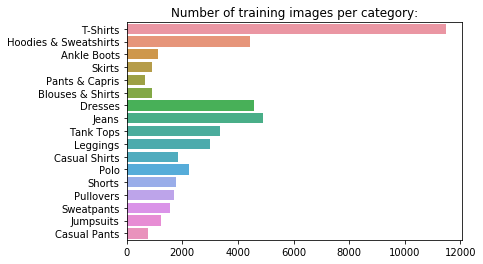

In [28]:
train_data_dir = "data/train"
val_data_dir = "data/val"
test_data_dir = "data/test"

img_pr_cat = []

for category in relevant_categories:
    folder = 'data/train/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=relevant_categories, x=img_pr_cat).set_title("Number of training images per category:")

In [74]:
batch_size = 32

train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)

# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical"
)
print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
    val_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=False
)
print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=False
)

Total number of images for "training":
Found 46451 images belonging to 17 classes.
Total number of images for "validation":
Found 5805 images belonging to 17 classes.
Total number of images for "testing":
Found 5815 images belonging to 17 classes.


In [76]:
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [77]:
history = model.fit_generator(my_gen(train_generator), 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=my_gen(val_generator),
                              callbacks=[checkpoint]
                              )

Epoch 1/10


KeyboardInterrupt: 

In [43]:
for x in train_generator:
    for y in x:
        print(str(y.shape) + '\n\n')
    break

(32, 224, 224, 3)


(32, 17)




In [53]:
model.predict(np.array([x[0][0]]))

array([[1.]], dtype=float32)